<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Python-Imports" data-toc-modified-id="Python-Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Python Imports</a></span></li><li><span><a href="#Loading-and-Preprocessing-data" data-toc-modified-id="Loading-and-Preprocessing-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loading and Preprocessing data</a></span></li><li><span><a href="#Data-visualization" data-toc-modified-id="Data-visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data visualization</a></span></li><li><span><a href="#Learning-Rate-Experiment" data-toc-modified-id="Learning-Rate-Experiment-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Learning Rate Experiment</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Running-the-experiment" data-toc-modified-id="Running-the-experiment-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Running the experiment</a></span></li><li><span><a href="#Saving-experiment-results" data-toc-modified-id="Saving-experiment-results-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Saving experiment results</a></span></li><li><span><a href="#(opt)-Load-learning-rate-experiment-data-from-file" data-toc-modified-id="(opt)-Load-learning-rate-experiment-data-from-file-5.0.3"><span class="toc-item-num">5.0.3&nbsp;&nbsp;</span>(opt) Load learning rate experiment data from file</a></span></li></ul></li></ul></li><li><span><a href="#Visualizing-experiment-results" data-toc-modified-id="Visualizing-experiment-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualizing experiment results</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Processing-raw-data" data-toc-modified-id="Processing-raw-data-6.0.1"><span class="toc-item-num">6.0.1&nbsp;&nbsp;</span>Processing raw data</a></span></li><li><span><a href="#Plot-learning-rate-experiment-data" data-toc-modified-id="Plot-learning-rate-experiment-data-6.0.2"><span class="toc-item-num">6.0.2&nbsp;&nbsp;</span>Plot learning rate experiment data</a></span></li></ul></li></ul></li><li><span><a href="#Experiment-Results-Discussion" data-toc-modified-id="Experiment-Results-Discussion-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Experiment Results Discussion</a></span></li></ul></div>

# Introduction

In this notebook we will run through a neural network pipeline using the MNIST dataset. The MNIST dataset consists of 60,000 images of handwritten digits with their corresponding labels for training, and another 10,000 images + labels for validation. 

We will train a perceptron network with 784 input + 1 bias perceptrons, 10 hidden layer perceptrons, and 1 output perceptron. The goal is to use a perceptron learning rule with a simple threshold activation function to train a network to identify handwritten digits. We will train the network with different learning rates to understand how quickly (or if) our network converges to a prediction accuracy.

# Python Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import pickle
from collections import defaultdict

from nnrunner import Network

# Loading and Preprocessing data

Data is loaded from two provided CSV files and scaled so that the 8-bit pixel value range falls between 0 and 1 for training efficiency.

In [2]:
init_start = time.time()

train = pd.read_csv('mnist_train.csv', header=None)
train_load = time.time()
print("Loaded mnist training data in %.4ss" % (train_load - init_start))

test = pd.read_csv('mnist_test.csv', header=None)
test_load = time.time()
print("Loaded mnist test data in %.4ss" % (test_load - train_load))

training_data = [(train.iloc[i][1:].values/255.0, train.iloc[i][0]) for i in range(len(train))]
train_proc = time.time()
print("Processed training data in %.4ss" % (train_proc - test_load))

test_proc = time.time()
test_data = [(test.iloc[i][1:].values/255.0, test.iloc[i][0]) for i in range(len(test))]
print("Processed test data in %.4ss" % (test_proc - train_proc))

print("Finished loading and processing mnist data.")


Loaded mnist training data in 3.55s
Loaded mnist test data in 0.62s
Processed training data in 11.5s
Processed test data in 0.0s
Finished loading and processing mnist data.


# Splitting Training Data Uniformly


Here we want to split the training data into two subsets of size 60000/4 and 60000/2

We have 10 digits to represent, so for the data subset of size 30,000, this means each digit will have 3000 examples.

For the data subset of size 15,000, each digit will have 1500 examples.

We proceed by iterating through a pandas dataframe that contains our data in the form of (data, label). We first build up a list of indices where each label occurs in the dataframe and choose 3000+1500 indices from that list for each digit. We then build a new dataframe from the lists of indices and randomly shuffle it. This way we will have two sets of data with different training examples that contain an even distribution of digits and is unsorted.



Here we append the bias to each input feature

In [7]:
def pandas_append(x):
    return np.append(x, 1.0)

In [5]:
train_size = len(training_data)
half_train_dig = (train_size // 2) // 10
qrter_train_dig = (train_size // 4) // 10

training_df = pd.DataFrame(training_data, columns=['data', 'label'])
training_df['data'] = training_df['data'].apply(pandas_append, 1)

half_train = []
qrter_train = []
for i in range(10):
    idxs = training_df.index[training_df['label'] == i].tolist()
    np.random.shuffle(idxs)
    half_train.extend(training_df.values[idxs[:half_train_dig]])
    qrter_train.extend(training_df.values[idxs[half_train_dig:half_train_dig + qrter_train_dig]])
    
np.random.shuffle(half_train)
np.random.shuffle(qrter_train)
    

In [6]:
fname = f"half_train.data"
with open("data/" + fname, "wb") as f:
    pickle.dump(half_train, f)

fname = f"qrter_train.data"
with open("data/" + fname, "wb") as f:
    pickle.dump(qrter_train, f)

# Data visualization

Once the data is loaded, we draw the images as a first pass at exploring the data. We may also look to see if the distribution of numbers represented in the dataset is uniform.

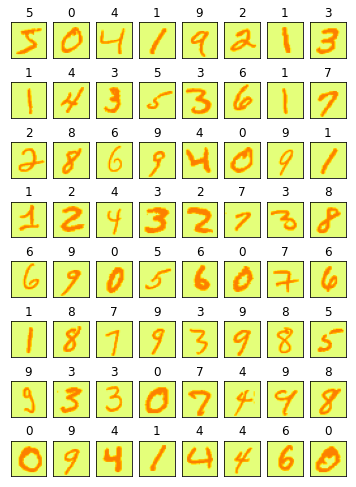

In [3]:
grid_size = 8
fig, ax = plt.subplots(grid_size, grid_size)
plt.subplots_adjust(top=1.75)
for i in range(grid_size**2):
    cur_ax = ax[i//grid_size][i%grid_size]
    img = np.array(train.iloc[i][1:])
    img = np.reshape(img, (28,28))
    
    cur_ax.set_yticklabels([])
    cur_ax.set_xticklabels([])
    cur_ax.set_yticks([])
    cur_ax.set_xticks([])
    
    cur_ax.set_title(train.iloc[i][0])
    cur_ax.imshow(img, cmap='Wistia', interpolation='hanning')

# Learning Rate Experiment

In this experiment, we will train the perceptron network with three different learning rates: 0.1, 0.01, 0.001. 
The network in each case will be initialized with the following parameters:
* A random set of weights taken from a normal distribution with values  between -0.05 and 0.05
* Stochastic gradient descent will be applied by modifying weights after looking at a subset of 10 images
* Training over the full training dataset will be repeated for 50 epochs

We choose to start with a set of weights randomly distributed about 0 in order to not systematically bias the network to favor some features over others. In ideal conditions, after a number of training epochs we would then expect to find that the weights reflect feature relevance. We also apply stochastic gradient descent over the training set by selecting a random subset from the training data to work on before updating the weights. In this experiment, a subset size of 10 means that we will update the weights in batches of 10 images over the full training set. The number of epochs is given as 50, and is generally used to checkpoint how well our model (including initialization parameters) converge to a good accuracy (fraction correct / total guesses). Lastly, the size of the learning rate tells the model how much to react to an incorrect guess, this is shown in the below equation

$$\Delta w_i = - \eta \left(t^k - y^k \right) x_i^k$$

where $\eta$ is the learning rate, $t^k$ is the target label, $y^k$ is the model prediction, $\Delta w_i$ is the change in the ith weight, and $x_i^k$ is the feature corresponding to both i and k. In picking a learning rate, we seek a good balance between punishing mistakes by picking a large learning rate to quickly get in the right ballpark and a small learning rate to slowly converge to the right answer.

### Running the experiment

In [4]:
# Initialization
learning_rate_results = []
learning_rates = [0.001, 0.01, 0.1]

In [6]:
eta_start = time.time()
for eta in learning_rates:
    net = Network(eta=eta)
    learning_rate_results.append(net.Train(training_data, test_data)) # accuracy for each learning rate after each epoch
    
print(f"Completed learning rate experiment in {(time.time() - eta_start)/60.0:.2f} minutes")

Training results written to file.
Training results written to file.
Training results written to file.
Completed learning rate experiment in 23.32 minutes


### Saving experiment results

In [7]:
badchars = [" ", ":"]
fname = f"learning_rate_exp_results_{str(datetime.now()).translate({ord(x): '_' for x in badchars})}_{'_'.join(map(str, learning_rates))}.data"
with open("results/" + fname, "wb") as f:
    pickle.dump(learning_rate_results, f)
    
print("Learning rate experiment results written to file.")

Learning rate experiment results written to file.


### (opt) Load learning rate experiment data from file

In [4]:
fname = "learning_rate_exp_results_2020-01-21_18_26_34.879405_0.001_0.01_0.1.data"
with open("results/" + fname, "rb") as f:
    learning_rate_results = pickle.load(f)

# Visualizing experiment results

### Processing raw data

In [9]:
eta_exp_training = []
eta_exp_test = []
eta_conf_matrix = []

for result in learning_rate_results:
    eta_exp_training.append([100*x for x, y in result])
    eta_exp_test.append([100*y[0] for x, y in result])
    eta_conf_matrix.append([y[1] for x, y in result])

matrices = defaultdict(list)
k = 0
for m in eta_conf_matrix:
    for i in range(10):
        matrices[k].append([m[-1][(i, j)] for j in range(10)])
    k+=1

### Plot learning rate experiment data

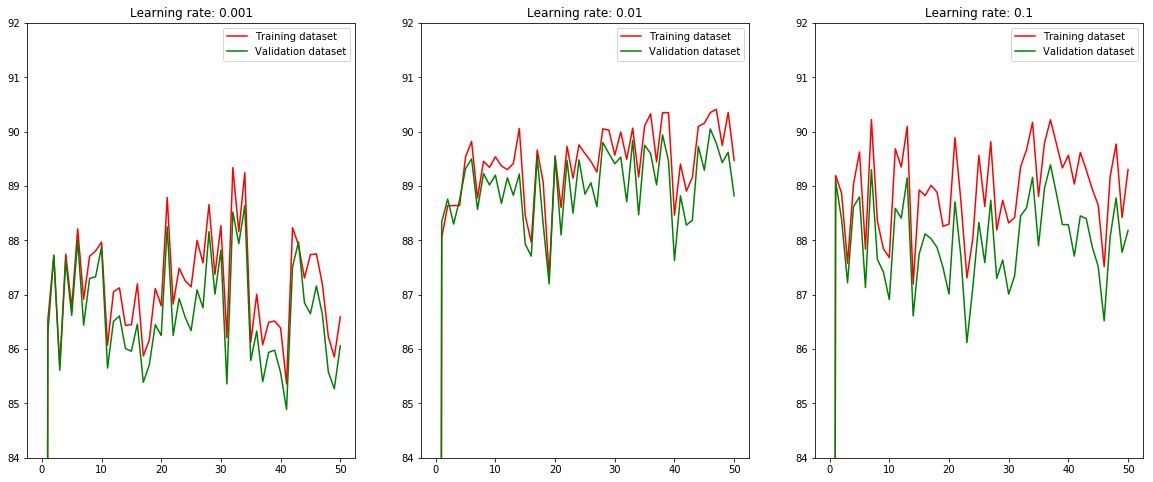

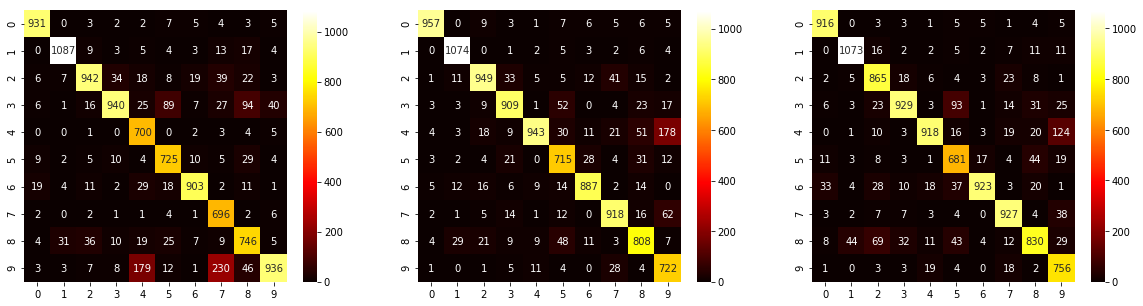

In [69]:
fig, axes = plt.subplots(1,3, figsize=(20, 8))
xaxi = list(range(51)) # 1 + number of epochs
for i, ax in enumerate(axes):
    ax.set(title=f"Learning rate: {learning_rates[i]}", ylim=[84, 92])
    train_line, = ax.plot(xaxi, eta_exp_training[i], 'r-')
    train_line.set_label("Training dataset")
    test_line, = ax.plot(xaxi, eta_exp_test[i], 'g-')
    test_line.set_label("Validation dataset")
    ax.legend()
    
import seaborn as sn
eta_conf_01 = pd.DataFrame(matrices[0], index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
eta_conf_02 = pd.DataFrame(matrices[1], index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
eta_conf_03 = pd.DataFrame(matrices[2], index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])

cm_fig, cm_axes = plt.subplots(1,3, figsize = (20, 5))
sn.heatmap(eta_conf_01, ax=cm_axes[0], annot=True, cmap='hot', fmt='g')
sn.heatmap(eta_conf_02, ax=cm_axes[1], annot=True, cmap='hot', fmt='g')
sn.heatmap(eta_conf_03, ax=cm_axes[2], annot=True, cmap='hot', fmt='g')

# Experiment Results Discussion

After each epoch of training, we test the model by generating predictions using the validation/test and training dataset. We then plot the accuracies without training (epoch 0) and with training (epochs 1-50). Epoch 0 accuracy is not shown but is typically within the range 7-12%. We find that for each learning rate and after a single epoch of training, our model is predicting with >85% accuracy on the training and validation datasets. A reason for this fast settling could be that the size of the learning rate is large relative to the value of weights and features (see above equation). We also find that no model converges to a value with small variance. This could be due to the threshold-based activation function which could be causing the model to over- and under-correct, leading to the oscillatory-like movement of the accuracy vs epochs. Our model does not appear to be overfitting as the difference in accuracy between validation and training datasets is not large (usually within 1%).

To look closer at our model, we use a confusion matrix to build a table of what our model's label prediction and the actual label. Each row shows a predicted label, while each column shows the actual target. At the intersecting cell, we have a count of the number of times the model predicted a number with a given target. Along the diagonal then is the number of times our model predicted correctly for a given digit. We find that the smallest learning rate is often confusing 9s with 4s  and 7s and 3s with 5s and 8s. Given the digit shapes aren't too dissimilar this makes sense. Also interesting to note that the rest of the cells in the table don't exceed 50. The larger learning rates (0.01 and 0.1) is not confusing any one digit as often, but there are more cells with counts >50. This suggests that the smaller learning rate gets us a model that generally tests well save for a few cases of confusion which drive down the overall accuracy (seen in the plot where the smallest learning rate hovers around 87% compared to 89% and 88% with a large variance). 


In [93]:
half_train

0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.45490196, 0.66666667, 0.84705882,
        0.23529412, 0.58431373, 0.92156863, 0.19215686, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.42352941,
        0.96470588, 0.99215686, 0.97647059, 0.95686275, 0.99215686,
        0.98431373, 0.84705882, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.  